In [1]:
import gradio as gr
import json
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
import sys

# Sets Current Directory to Parent Path
sys.path.insert(0, '..')

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from src.utils.main import download_dataset, convert_dataset

In [2]:
DATASET_URL = 'https://github.com/yaleemmlc/admissionprediction/raw/master/Results/5v_cleandf.RData'
FILE_PATH = '../data'
FILE_NAME = 'Results.rdata'

# Downloads the Original Dataset (RData File)
DATASET_RDATA_PATH = download_dataset(DATASET_URL, FILE_PATH, FILE_NAME)

# Converts the RData File to a New CSV File
DATASET_CSV_PATH = convert_dataset(DATASET_RDATA_PATH, DATASET_RDATA_PATH.replace('.rdata', '.csv'))

In [3]:
df = pl.read_csv(DATASET_CSV_PATH)

df.head()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,arrivalmonth,arrivalday,arrivalhour_bin,previousdispo,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,acutemi,acutphanm,adjustmentdisorders,adltrespfl,alcoholrelateddisorders,allergy,amniosdx,analrectal,anemia,aneurysm,anxietydisorders,appendicitis,…,cc_shortnessofbreath,cc_shoulderinjury,cc_shoulderpain,cc_sicklecellpain,cc_sinusproblem,cc_skinirritation,cc_skinproblem,cc_sorethroat,cc_stdcheck,cc_strokealert,cc_suicidal,cc_suture/stapleremoval,cc_swallowedforeignbody,cc_syncope,cc_tachycardia,cc_testiclepain,cc_thumbinjury,cc_tickremoval,cc_toeinjury,cc_toepain,cc_trauma,cc_unresponsive,cc_uri,cc_urinaryfrequency,cc_urinaryretention,cc_urinarytractinfection,cc_vaginalbleeding,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
i64,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,"""B""",4,40,"""Male""","""Hispanic or La…","""White or Cauca…","""English""","""None""","""Single""","""Full Time""","""Other""","""Discharge""","""Walk-in""","""June""","""Tuesday""","""23-02""","""No previous di…",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"""B""",4,66,"""Male""","""Hispanic or La…","""Native Hawaiia…","""English""","""Pentecostal""","""Married""","""Not Employed""","""Commercial""","""Discharge""","""Car""","""January""","""Tuesday""","""15-18""","""No previous di…",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"""B""",2,66,"""Male""","""Hispanic or La…","""Native Hawaiia…","""English""","""Pentecostal""","""Married""","""Not Employed""","""Commercial""","""Discharge""","""Walk-in""","""July""","""Thursday""","""11-14""","""Discharge""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"""A""",2,66,"""Male""","""Hispanic or La…","""Native Hawaiia…","""English""","""Pentecostal""","""Married""","""Not Employed""","""Commercial""","""Discharge""","""Car""","""July""","""Saturday""","""11-14""","""Discharge""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"""A""",3,84,"""Female""","""Hispanic or La…","""Other""","""Other""","""Pentecostal""","""Widowed""","""Retired""","""Medicare""","""Admit""","""Walk-in""","""November""","""Tuesday""","""07-10""","""Discharge""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df.describe()

describe,,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,arrivalmonth,arrivalday,arrivalhour_bin,previousdispo,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,acutemi,acutphanm,adjustmentdisorders,adltrespfl,alcoholrelateddisorders,allergy,amniosdx,analrectal,anemia,aneurysm,anxietydisorders,…,cc_shortnessofbreath,cc_shoulderinjury,cc_shoulderpain,cc_sicklecellpain,cc_sinusproblem,cc_skinirritation,cc_skinproblem,cc_sorethroat,cc_stdcheck,cc_strokealert,cc_suicidal,cc_suture/stapleremoval,cc_swallowedforeignbody,cc_syncope,cc_tachycardia,cc_testiclepain,cc_thumbinjury,cc_tickremoval,cc_toeinjury,cc_toepain,cc_trauma,cc_unresponsive,cc_uri,cc_urinaryfrequency,cc_urinaryretention,cc_urinarytractinfection,cc_vaginalbleeding,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",560486.0,"""560486""",558029.0,560475.0,"""560486""","""560486""","""560460""","""560486""","""560486""","""560486""","""560486""","""560486""","""560486""","""538602""","""560486""","""560486""","""560486""","""560486""",560486.0,560486.0,560486.0,560486.0,560486.0,560486.0,560486.0,560486.0,560486.0,560486.0,560486.0,560486.0,560486.0,560486.0,560486.0,560486.0,560486.0,560486.0,…,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0,557901.0
"""null_count""",0.0,"""0""",2457.0,11.0,"""0""","""0""","""26""","""0""","""0""","""0""","""0""","""0""","""0""","""21884""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0,2585.0
"""mean""",280242.5,null,3.012385,49.876765,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.002155,0.030634,0.014807,0.000023,0.005179,0.009968,0.051054,0.035844,0.000459,0.001633,0.007122,0.055909,0.04586,0.000153,0.004644,0.084737,0.010712,0.199432,…,0.044212,0.001999,0.007471,0.002074,0.000988,0.001798,0.002262,0.013479,0.001552,0.003963,0.014958,0.003099,0.000661,0.008978,0.002024,0.001357,0.000816,0.000701,0.001101,0.002198,0.000855,0.001832,0.003187,0.000925,0.001981,0.004356,0.00725,0.001298,0.000717,0.013085,0.001052,0.001165,0.004219,0.002863,0.001233,0.001393,0.002518
"""std""",161798.515826,null,0.869106,20.417029,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.046375,0.172324,0.120779,0.004816,0.071782,0.099342,0.220108,0.185901,0.021408,0.040371,0.084093,0.229745,0.209182,0.012386,0.06799,0.27849,0.102944,0.399574,…,0.205627,0.044661,0.086132,0.045492,0.031411,0.042362,0.047507,0.115361,0.039368,0.062828,0.121399,0.055583,0.025709,0.094347,0.04494,0.036811,0.028546,0.026464,0.033156,0.046865,0.029228,0.042803,0.056458,0.030398,0.04446,0.065853,0.08484,0.036001,0.0269,0.113638,0.032475,0.034113,0.06482,0.053426,0.035095,0.037293,0.050156
"""min""",0.0,"""A""",1.0,18.0,"""Female""","""Hispanic or La…","""American India…","""English""","""Baptist""","""Civil Union""","""Disabled""","""Commercial""","""Admit""","""Car""","""April""","""Friday""","""03-06""","""AMA""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [5]:
# Removes the First Column (Index)
df = df.drop("")

# columns = dict()
# for column in df.columns:
#     columns[column] = df[column].unique().sort().to_list()

# with open("columns.json", "w") as outfile:
#     outfile.write(json.dumps(columns, indent=4))

# Elimina las columnas donde todos sus elementos sean iguales
columns_to_remove = df.columns[df.n_unique() == 1]
df_witout_nunique = df.drop(columns=columns_to_remove)
df_witout_nunique.head()

C:\Users\verge\AppData\Local\Temp\ipykernel_5352\3345429919.py:13: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  df_witout_nunique = df.drop(columns=columns_to_remove)


esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,arrivalmonth,arrivalday,arrivalhour_bin,previousdispo,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,acutemi,acutphanm,adjustmentdisorders,adltrespfl,alcoholrelateddisorders,allergy,amniosdx,analrectal,anemia,aneurysm,anxietydisorders,appendicitis,artembolism,asppneumon,…,cc_shortnessofbreath,cc_shoulderinjury,cc_shoulderpain,cc_sicklecellpain,cc_sinusproblem,cc_skinirritation,cc_skinproblem,cc_sorethroat,cc_stdcheck,cc_strokealert,cc_suicidal,cc_suture/stapleremoval,cc_swallowedforeignbody,cc_syncope,cc_tachycardia,cc_testiclepain,cc_thumbinjury,cc_tickremoval,cc_toeinjury,cc_toepain,cc_trauma,cc_unresponsive,cc_uri,cc_urinaryfrequency,cc_urinaryretention,cc_urinarytractinfection,cc_vaginalbleeding,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
4,40,"""Male""","""Hispanic or La…","""White or Cauca…","""English""","""None""","""Single""","""Full Time""","""Other""","""Discharge""","""Walk-in""","""June""","""Tuesday""","""23-02""","""No previous di…",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,66,"""Male""","""Hispanic or La…","""Native Hawaiia…","""English""","""Pentecostal""","""Married""","""Not Employed""","""Commercial""","""Discharge""","""Car""","""January""","""Tuesday""","""15-18""","""No previous di…",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,66,"""Male""","""Hispanic or La…","""Native Hawaiia…","""English""","""Pentecostal""","""Married""","""Not Employed""","""Commercial""","""Discharge""","""Walk-in""","""July""","""Thursday""","""11-14""","""Discharge""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,66,"""Male""","""Hispanic or La…","""Native Hawaiia…","""English""","""Pentecostal""","""Married""","""Not Employed""","""Commercial""","""Discharge""","""Car""","""July""","""Saturday""","""11-14""","""Discharge""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,84,"""Female""","""Hispanic or La…","""Other""","""Other""","""Pentecostal""","""Widowed""","""Retired""","""Medicare""","""Admit""","""Walk-in""","""November""","""Tuesday""","""07-10""","""Discharge""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
significantColumns = ['cc_chestpain', 'cc_breathingdifficulty', 'cc_syncope', 'cc_unresponsive', 'cc_seizure-newonset', 'cc_seizure-priorhxof', 'cc_seizures', 'cc_bleeding/bruising', 'cc_hyperglycemia', 'cc_hypertension', 'cc_hypotension', 'cc_strokealert', 'cc_overdose-accidental', 'cc_overdose-intentional', 'cc_suicidal']

In [7]:
# If any of the significant columns are on true, automatically has the flag of emergency
df_witout_nunique = df_witout_nunique.to_pandas()
df_witout_nunique['emergency_flag_column'] = df_witout_nunique[significantColumns].any(axis=1)

print(df_witout_nunique['emergency_flag_column'].value_counts())

emergency_flag_column
False    493625
True      66861
Name: count, dtype: int64


In [8]:
df_converted = df_witout_nunique.copy()

# Inicializar el codificador de etiquetas
label_encoder = LabelEncoder()

# Identificar las variables categóricas
categorical_columns = []
for column in df_converted.columns:
    # Verificar si la columna es de tipo 'object' o 'category'
    if df_converted[column].dtype == 'object' or df_converted[column].dtype == 'category' :  
        categorical_columns.append(column)

# Convertir las variables categóricas usando LabelEncoder
for column in categorical_columns:
    df_converted[column] = label_encoder.fit_transform(df_converted[column])

print(df_converted['gender'].value_counts())


gender
0    309653
1    250833
Name: count, dtype: int64


In [9]:
columnsWithNan = df_converted.isna().any().pipe(lambda x: x.index[x])
print(len(columnsWithNan))

# Reemplazo los valores nulos con -999. Se podría intentar en una proxima iteracion con algo como col.mode()[0] o valores significativos reales
df_filled = df_converted.apply(lambda col: col.fillna(-999))

newColumnsWithNan = df_filled.isna().any().pipe(lambda x: x.index[x])
print(len(newColumnsWithNan))


569
0


In [10]:
# División de datos
random_state = 42

X = df_filled.drop(columns=['emergency_flag_column'])
y = df_filled['emergency_flag_column']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [11]:
# Entrenamiento del modelo
model = RandomForestClassifier(n_estimators=100, random_state=random_state)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Validación del modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9971631964887866


In [13]:
confusion = confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
FP = confusion[0, 1]
TN = confusion[0, 0]
FN = confusion[1, 0]

print(f"Verdaderos Positivos: {str(TP)}")

Verdaderos Positivos: 12833


In [14]:
# Codificación de variables categóricas
df_encoded = pd.get_dummies(df_witout_nunique)

In [15]:
# Manejo de valores nulos
imputer = SimpleImputer(strategy='most_frequent')  
df_without_null = imputer.fit_transform(df_witout_nunique)
print(df_without_null)

[[4.0 40.0 'Male' ... 0.0 0.0 False]
 [4.0 66.0 'Male' ... 0.0 0.0 False]
 [2.0 66.0 'Male' ... 0.0 0.0 False]
 ...
 [3.0 50.0 'Male' ... 0.0 0.0 False]
 [3.0 50.0 'Male' ... 0.0 0.0 False]
 [3.0 50.0 'Male' ... 0.0 0.0 False]]


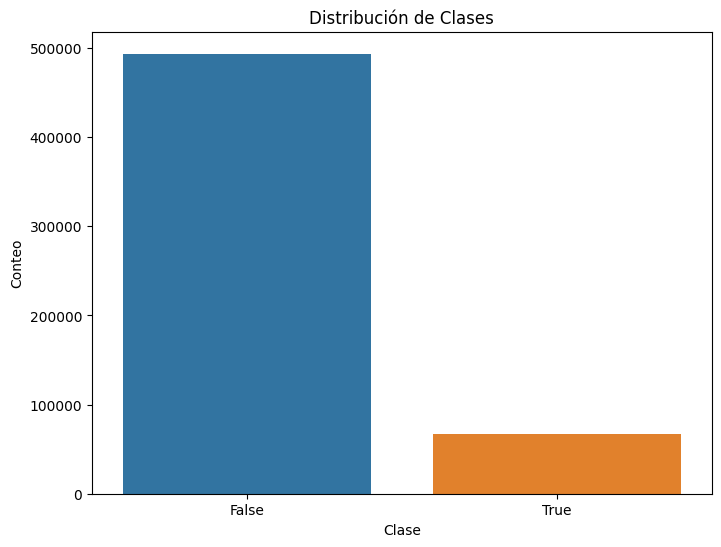

In [16]:
# Crear un DataFrame con las características y las etiquetas codificadas
df_plot = X.copy()
df_plot['emergency_flag'] = y

# Graficar la distribución de las clases
plt.figure(figsize=(8, 6))
sns.countplot(x='emergency_flag', data=df_plot)
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Conteo')
plt.show()